In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook demonstrates the process for a single-engine piston aircraft - the figures are broadly based on **G-OUAV**, a **Sherwood Scout** operated by the University of Southampton Aviation Society.*

### Before you start... click on the video below for an introduction and a 'user's guide'
<!-- http://img.youtube.com/vi/TMM7mE1NjaE/0.jpg -->
[![4. Wing and propulsion system sizing](../img/sherwoodscout_yt_thumbnail.jpg)](https://www.youtube.com/watch?v=TMM7mE1NjaE)

> ⚠️ **If you are following along at home**: ADRpy has undergone some changes since the publication of this video. If things look slightly different, it's a good idea to compare and contrast what's here in the notebook to the video guide.

### Preamble

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as uc
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Constraint Analysis of the Sherwood Scout

We consider a design for which the constraints are built on standard day conditions in the International Standard Atmosphere.

In [3]:
designatm = at.Atmosphere()

We take pointers for building a dictionary of performance requirements from the Pilot's operating handbook [[1]](#References), a brochure from the manufacturer [[2]](#References), and a light aircraft review article [[3]](#References).

In [4]:
nturn = 1 / np.cos(np.radians(60))

designbrief = {
    'rwyelevation_m':0.0, 'groundrun_m': 90.0,                             # <- Take-off requirements
    'stloadfactor': nturn, 'turnalt_m': 3e3, 'turnspeed_ktas': 70,         # <- Turn requirements
    'climbalt_m': 3e3, 'climbspeed_kias': 47, 'climbrate_fpm': 630,        # <- Climb requirements
    'cruisealt_m': 3e3, 'cruisespeed_ktas': 110, 'cruisethrustfact': 1.0,  # <- Cruise requirements
    'servceil_m': uc.ft_m(12e3), 'secclimbspd_kias': 47,                   # <- Service ceiling requirements
    'vstallclean_kcas': 36                                                 # <- Required clean stall speed
}

In [5]:
TOW_kg = 450

In [6]:
scout_Swing = uc.ft2_m2(108)
scout_bspan = uc.ft_m(28.5)

AR = scout_bspan ** 2 / scout_Swing   # AR = b^2 / S

wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 1.0, 'servceil': 1.0}

designdefinition = {
    'aspectratio':AR, 'sweep_le_deg':0, 'sweep_mt_deg':0,   # <- Wing geometry
    'weightfractions': wfract, 'weight_n': uc.kg_N(TOW_kg)  # <- Weight definitions
}

designpropulsion = "Piston"

What's much harder to estimate is the propeller efficiencies for different phases of flight and the aerodynamic coefficients.

In [7]:
etas = {'take-off': 0.5, 'climb': 0.6, 'cruise': 0.8, 'turn': 0.75, 'servceil': 0.6}

designperformance = {
    'CLTO': 0.4, 'CLmaxTO': 1.4, 'mu_R': 0.03,     # <- Take-off specific performance
    'CLmax': 2.1, 'CDmin': 0.04, 'eta_prop': etas  # <- General performance
}

At first glance the clean $C_{L\text{max}}$ seems quite high, however, this is what is required to meet the manufacturer's claimed stall performance.
It's the only variable we can change to satisfy the lift equation!

$$W_{\text{MTOW}} = L = \tfrac{1}{2}\rho {V_{S1}}^2 \cdot S \cdot C_{L\text{max}}$$

Everything is now ready for the instantiation of an aircraft concept object, which will serve as the input to the constraint analysis:

In [8]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)

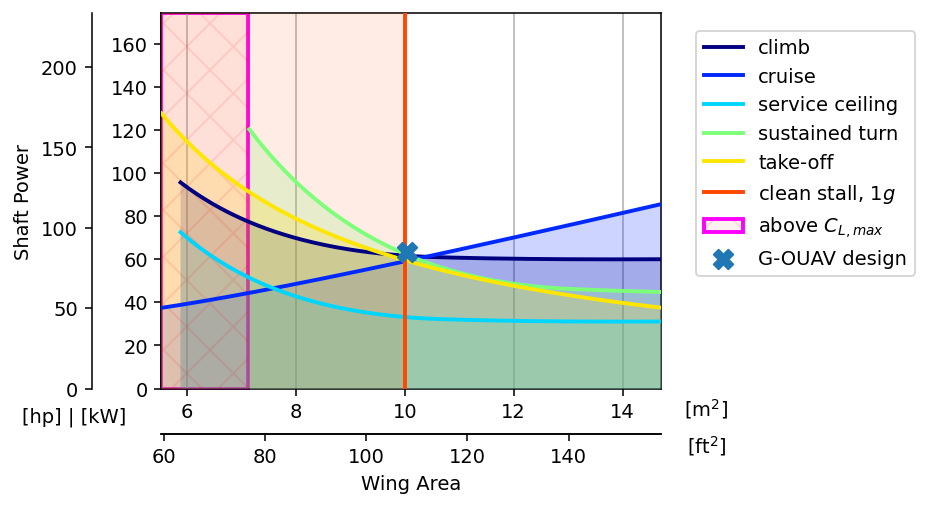

In [9]:
wslist_pa = np.arange(300, 800, 2.5)

fig, ax = concept.plot_constraints(wslist_pa)

scout_power = uc.hp_W(85)  # Jabiru 2200 85 hp

ax.scatter(
    scout_Swing, scout_power, label="G-OUAV design",
    marker="X", s=100, zorder=100
)
ax.remake_legend();

While the design appears to be well balanced in all constraints besides service ceiling, it is important to reconcile performance estimates with what we might expect from similar aircraft.
For example, it doesn't necessarily make sense to operate the engine at a `cruisethrustfact` of 100% in single engine piston propeller aircraft - in fact, many POH's recommend operating in regimes 60~80% of the maximum performance to maximise endurance.
How sure are we that the $C_{D_{\text{min}}}$ is anywhere near what we guessed?

The more confidence you can place into more parameters, the easier time you'll have numerically solving for performance parameters that are genuinely difficult to estimate!

# References

[1] "Sherwood Scout Pilot's Operating Handbook & Maintenance Manual," The Light Aircraft Company, December 2021. Accessed: 25/12/2023. [Online]. Available: https://www.g-tlac.com/wp-content/uploads/2022/03/Sherwood-Scout-POH-MM-Rev-2-17-12-21.pdf.

[2] "Sherwood Scout Flyer," The Light Aircraft Company. Accessed: 30/12/2023. [Online]. Available: https://www.g-tlac.com/wp-content/uploads/2017/10/Sherwood-Scout-flyer.pdf.

[3] "Flight test: Sherwood Scout," Pilot, August 2019. Accessed: 30/12/2023. [Online]. Available: https://pilotweb.aero/aircraft/flight-tests/flight-test-sherwood-scout-6303232/.